In [100]:
import pyiron
import pyiron.vasp.structure

# Analytic description of grain boundary segregation, tension, and formation energy in the copper–nickel system

In [101]:
import numpy as np

In [102]:
import matplotlib.pyplot as plt

In [103]:
pr = pyiron.Project("segregation")

In [104]:
from pyiron.atomistics.structure.atoms import ase_to_pyiron
from ase.lattice.cubic import FaceCenteredCubic 

In [105]:
plt.rc('figure', figsize=(15,10))
plt.rc('font', size=20)

In [106]:
j.list_potentials()

['1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1',
 '1986--Foiles-S-M--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1',
 '1989--Adams-J-B--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1',
 '2004--Lee-B-J--Cu-Ni--LAMMPS--ipr1',
 '2009--Bonny-G--Fe-Cu-Ni--LAMMPS--ipr1',
 '2013--Onat-B--Cu-Ni--LAMMPS--ipr2',
 '2018--Farkas-D--Fe-Ni-Cr-Co-Cu--LAMMPS--ipr2',
 '2019--Fischer-F--Cu-Ni--LAMMPS--ipr1',
 '2019--Fischer-F--Cu-Ni--LAMMPS--ipr2',
 'EAM_Dynamo_BonnyPasianotCastin_2009_FeCuNi__MO_469343973171_005',
 'EAM_Dynamo_OnatDurukanoglu_2014_CuNi__MO_592013496703_005',
 'EMT_Asap_Standard_JacobsenStoltzeNorskov_1996_AlAgAuCuNiPdPt__MO_115316750986_001']

In [107]:
potential = '2019--Fischer-F--Cu-Ni--LAMMPS--ipr2'

## Bulk Reference Calc: Ni

In [108]:
def minimize_bulk(pr, element):
    j = pr.create_job(pr.job_type.Lammps, element + "_minimize_bulk")
    j.structure = pr.create_ase_bulk(element, cubic=True).repeat(3)
    j.potential = potential
    j.calc_minimize(pressure=0)
    j.run()
    j.animate_structure()
    return j.get_structure(), j.output.energy_pot[-1] / len(j.structure)

In [109]:
ni_bulk, energy_ni_bulk_atom = minimize_bulk(pr, 'Ni')

2020-11-23 13:04:35,772 - pyiron_log - WARNING - The job Ni_minimize_bulk is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


In [110]:
ni_bulk.plot3d()

NGLWidget()

## Build a GB: Ni

In [111]:
FaceCenteredCubic?

Signature:     
FaceCenteredCubic(
    symbol,
    directions=(None, None, None),
    miller=(None, None, None),
    size=(1, 1, 1),
    latticeconstant=None,
    pbc=True,
    align=True,
    debug=0,
)
Type:           FaceCenteredCubicFactory
String form:    <ase.lattice.cubic.FaceCenteredCubicFactory object at 0x2ac02b810210>
File:           /u/system/SLES12/soft/pyiron/dev/anaconda3/lib/python3.7/site-packages/ase/lattice/cubic.py
Docstring:      A factory for creating face-centered cubic lattices.
Call docstring: Create a lattice.


In [112]:
left = pyiron.ase_to_pyiron(FaceCenteredCubic('Ni', ((-1,0,3),(3,0,1),(0, 1, 0))))

In [113]:
left.set_repeat((4, 4, 1, ))

In [114]:
left.plot3d()

NGLWidget()

In [115]:
I = left.positions[:, 0] > left.cell[0, 0]/2
left.positions[I, 1] *= -1

In [116]:
left.plot3d()

NGLWidget()

In [117]:
left.center_coordinates_in_unit_cell();

In [118]:
left.plot3d()

NGLWidget()

In [119]:
neigh = left.get_neighbors(1)
del left[(neigh.distances < 2)[:,0] & (left.positions[:, 0] > left.cell[0, 0]/2)]

In [120]:
neigh.distances.shape, len(left)

((160, 1), 152)

In [121]:
def minimize_gb(pr, structure, element, ref_energy_bulk):
    j = pr.create_job(pr.job_type.Lammps, element.lower() + "_minimize_gb")
    j.structure = structure
    j.structure[:] = element
    j.potential = potential
    j.calc_minimize(pressure=0)
    j.run()
    return j, j.output.energy_pot[-1] - ref_energy_bulk * len(j.structure) 

In [122]:
j, energy_ni_gb_excess = minimize_gb(pr, left, 'Ni', energy_ni_bulk_atom)
gb_ni = gb = j.get_structure()
j.animate_structure(spacefill=True)

2020-11-23 13:04:39,002 - pyiron_log - WARNING - The job ni_minimize_gb is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


NGLWidget(max_frame=19)

In [123]:
energy_ni_gb_excess

13.294648444814925

In [124]:
gb.plot3d()

NGLWidget()

## Find Segregation Sites

In [125]:
equivalent_sites = gb.get_symmetry(symprec=1e-2)['equivalent_atoms']
gb_sites, idx, gb_degeneracy = np.unique(equivalent_sites, return_inverse=True, return_counts=True)

In [126]:
gb_degeneracy

array([ 8, 16,  8, 16, 16, 16, 16, 16, 16, 16,  8])

In [127]:
idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4,  5,  6,
        7,  8,  9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10,  8,  9,  6,  7,  5,  3,  4,  1,  2, 10,
        8,  9,  6,  7,  5,  3,  4,  1,  2, 10,  8,  9,  6,  7,  5,  3,  4,
        1,  2, 10,  8,  9,  6,  7,  5,  3,  4,  1,  2,  0,  1,  3,  4,  5,
        6,  7,  8,  9,  0,  1,  3,  4,  5,  6,  7,  8,  9,  0,  1,  3,  4,
        5,  6,  7,  8,  9,  0,  1,  3,  4,  5,  6,  7,  8,  9, 10,  8,  9,
        6,  7,  5,  3,  4,  1, 10,  8,  9,  6,  7,  5,  3,  4,  1, 10,  8,
        9,  6,  7,  5,  3,  4,  1, 10,  8,  9,  6,  7,  5,  3,  4,  1])

In [128]:
gb.plot3d(scalar_field=idx)

NGLWidget()

In [129]:
gb_sites

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 40], dtype=int32)

## Calculate bulk chemical potential of dilute solute: Cu in Ni

In [130]:
def calc_Δµ(pr, structure, solute, ref_energy):
    j = pr.create_job(pr.job_type.Lammps, solute.lower() + '_chem_pot')
    j.potential = potential
    j.structure = structure
    j.structure[0] = solute
    j.calc_minimize()
    j.run()
    return j.output.energy_tot[-1] - (len(j.structure) - 1) * ref_energy

In [131]:
Δµ_Cu = Δµ = calc_Δµ(pr, pr['Ni_minimize_bulk'].get_structure(), 'Cu', energy_ni_bulk_atom)

2020-11-23 13:04:44,569 - pyiron_log - WARNING - The job cu_chem_pot is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


In [132]:
print(Δµ)

-3.392071896192874


## Calculate Segregation Excess Energies: Cu in Ni

In [133]:
def segregate(pr, structure, gb_sites, solute, ref_energy_bulk, ref_gb_excess, Δµ):
    j = pr.create_job(pr.job_type.Lammps, solute.lower() + "_segregate")
    j.potential = potential
    j.structure = structure
    j.calc_minimize()
    j.interactive_open()
    for site in gb_sites:
        decorated = structure.copy()
        decorated[site] = solute
        j.structure = decorated
        j.run()
    j.interactive_close()
    return j, j.output.energy_pot - (len(j.structure)-1) * ref_energy_bulk - Δµ - ref_gb_excess

In [134]:
j, segregation_energies_cu = segregate(pr, gb, gb_sites, 'Cu', energy_ni_bulk_atom, energy_ni_gb_excess, Δµ_Cu)

2020-11-23 13:04:46,159 - pyiron_log - WARNING - The job cu_segregate is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2020-11-23 13:04:46,884 - pyiron_log - WARNING - The job cu_segregate is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2020-11-23 13:04:47,579 - pyiron_log - WARNING - The job cu_segregate is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2020-11-23 13:04:48,297 - pyiron_log - WARNING - The job cu_segregate is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2020-11-23 13:04:49,011 - pyiron_log - WARNING - The job cu_segregate is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2020-11-23 13:04:49,707 - pyiron_log - WARNING - The job cu_segregate is being loaded instead of running. To re-run use the argume

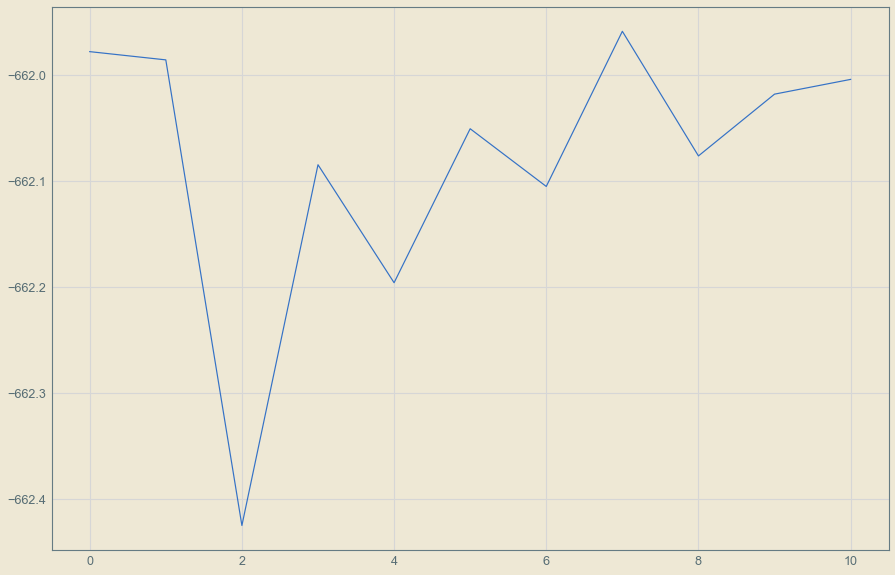

In [135]:
plt.plot(j.output.energy_pot)

In [136]:
j.get_structure(np.argmin(j.output.energy_pot)).plot3d()

NGLWidget()

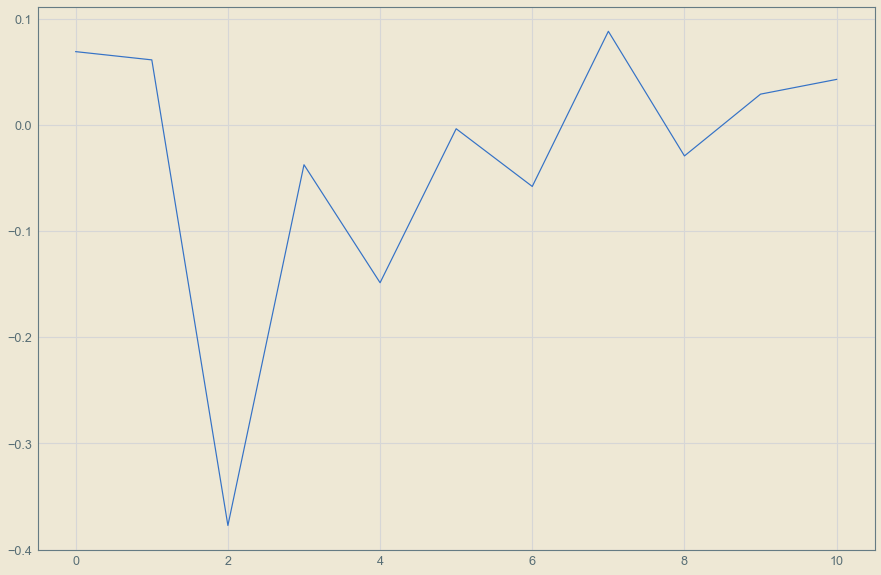

In [137]:
plt.plot(segregation_energies_cu)

## Predicting Segregation with McLean Isotherm

In [138]:
def occupation_excess(E, T, c): 
    import scipy
    kB=scipy.constants.physical_constants['Boltzmann constant in eV/K'][0] 
    # assume dilute chemical potential 
    return 1 / (1 + np.exp((E - kB*T*np.log(c/(1-c)))/kB/T )) - c

In [139]:
segregation_energies_cu

array([ 0.06937154,  0.06159819, -0.3773568 , -0.0372418 , -0.14848553,
       -0.00332437, -0.05772842,  0.08853156, -0.02895488,  0.02929882,
        0.04320366])

In [140]:
occupation_excess(segregation_energies_cu, 100, 0.2)

array([-0.19992025, -0.19980346,  0.8       ,  0.74957069,  0.79999987,
        0.06883983,  0.79509611, -0.19999137,  0.67801653, -0.19172561,
       -0.19834099])

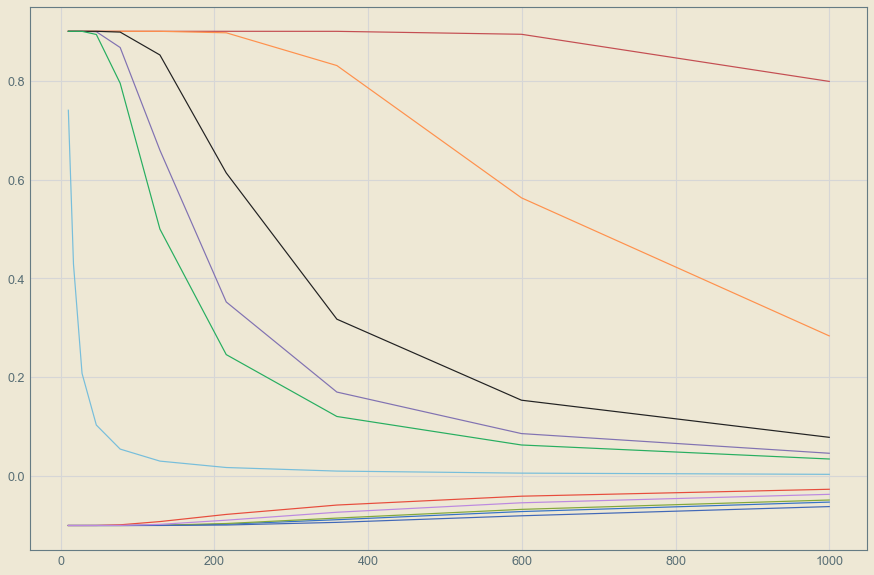

In [141]:
T = np.logspace(1, 3, 10)
for E in segregation_energies_cu:
    plt.plot(T, occupation_excess(E, T, .1))

### Combine Occupancy with Site Degeneracy

In [142]:
gb_degeneracy

array([ 8, 16,  8, 16, 16, 16, 16, 16, 16, 16,  8])

In first order $c=0.5$ is still dilute... ;)

In [143]:
cs = np.linspace(0, .5, 100)

In [144]:
def gb_excess(cs, segregation_energies, gb_degeneracy, T):
    gamma = np.array([ (gb_degeneracy*occupation_excess(segregation_energies, T, c)).sum() for c in cs])
    return gamma

/u/system/SLES12/soft/pyiron/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


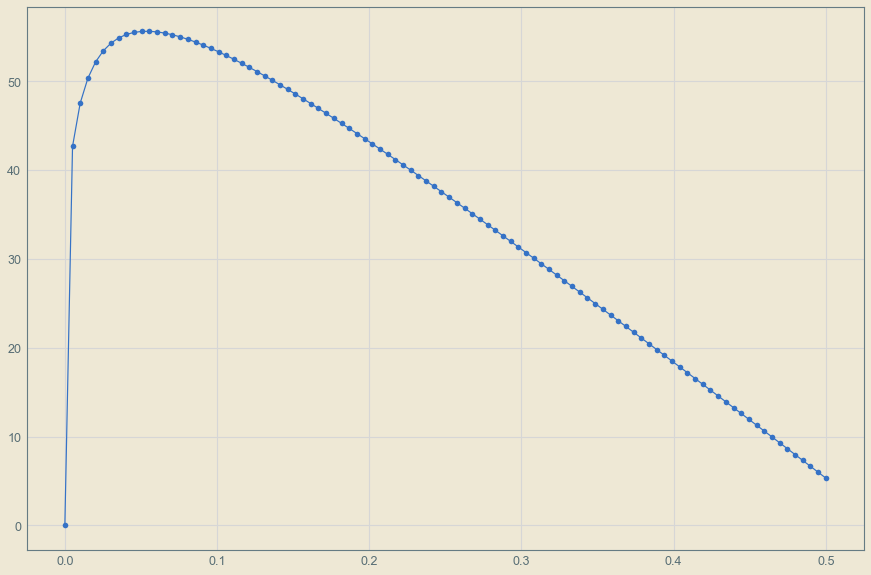

In [145]:
plt.plot(cs, gb_excess(cs, segregation_energies_cu, gb_degeneracy, 100), '-o')

# Repeat Calcs for Cu side

In [146]:
cu_bulk, energy_cu_bulk_atom = minimize_bulk(pr, 'Cu')
print(energy_cu_bulk_atom)

2020-11-23 13:04:56,324 - pyiron_log - WARNING - The job Cu_minimize_bulk is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


-3.5399999683805277


In [147]:
j, energy_cu_gb_excess = minimize_gb(pr, left, 'Cu', energy_cu_bulk_atom)
gb_cu = j.get_structure()
print(energy_cu_gb_excess)
gb_cu.plot3d()

2020-11-23 13:04:58,466 - pyiron_log - WARNING - The job cu_minimize_gb is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


9.170610912610186


NGLWidget()

In [148]:
Δµ_Ni = calc_Δµ(pr, cu_bulk, 'Ni', energy_cu_bulk_atom)

2020-11-23 13:05:00,742 - pyiron_log - WARNING - The job ni_chem_pot is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


2020-11-23 13:05:02,292 - pyiron_log - WARNING - The job ni_segregate is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2020-11-23 13:05:03,015 - pyiron_log - WARNING - The job ni_segregate is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2020-11-23 13:05:03,644 - pyiron_log - WARNING - The job ni_segregate is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2020-11-23 13:05:03,998 - pyiron_log - WARNING - The job ni_segregate is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2020-11-23 13:05:04,348 - pyiron_log - WARNING - The job ni_segregate is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2020-11-23 13:05:04,696 - pyiron_log - WARNING - The job ni_segregate is being loaded instead of running. To re-run use the argume

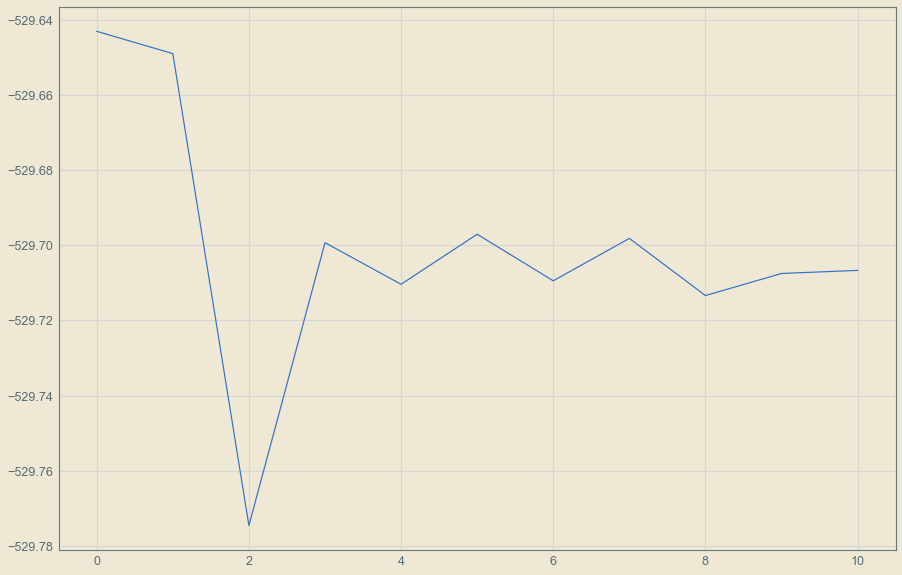

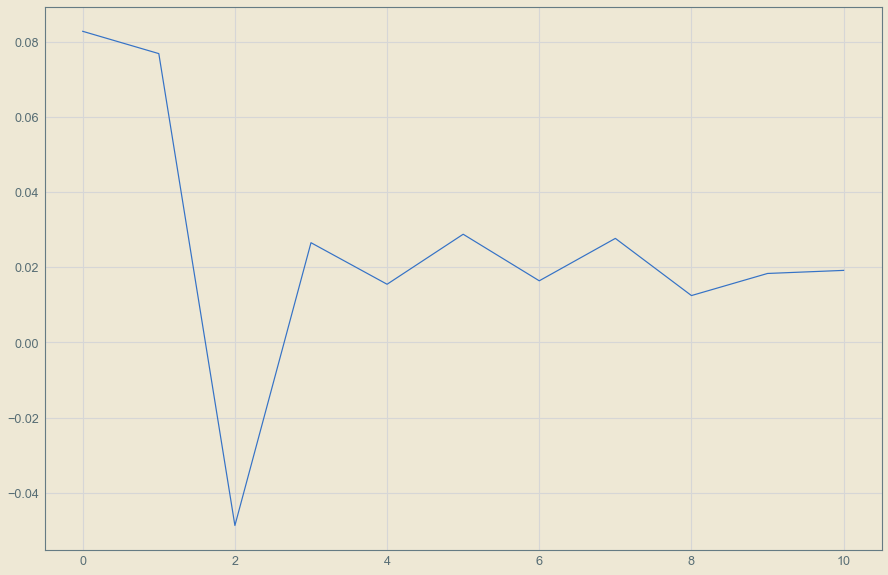

In [149]:
j, segregation_energies_ni = segregate(pr, gb_cu, gb_sites, 'Ni', energy_cu_bulk_atom, energy_cu_gb_excess, Δµ_Ni) 
plt.plot(j.output.energy_tot)
plt.figure()
plt.plot(segregation_energies_ni)

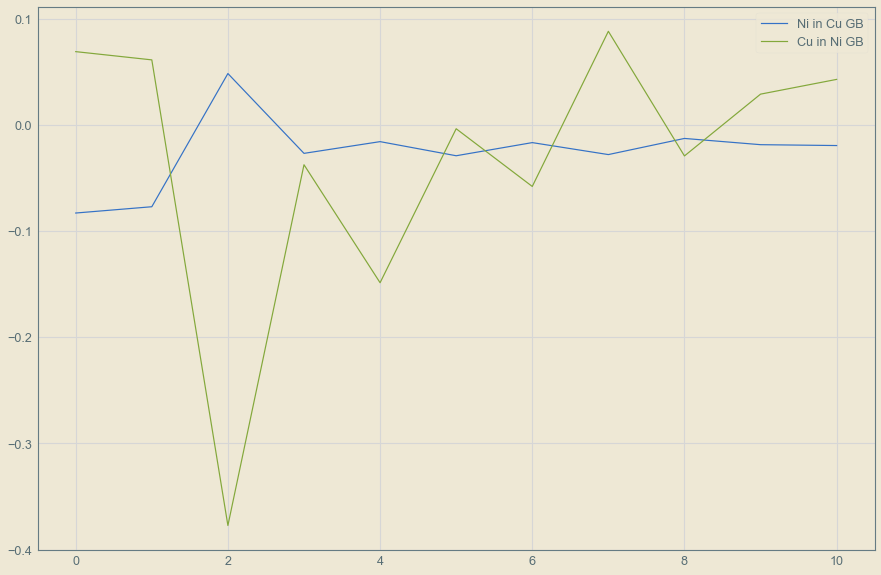

In [150]:
plt.plot(-segregation_energies_ni, label = 'Ni in Cu GB')
plt.plot(segregation_energies_cu, label = 'Cu in Ni GB')
plt.legend()

In [151]:
def interpolate_energies(c, e_cu = segregation_energies_cu, e_ni = -segregation_energies_ni):
    return e_cu + (e_ni - e_cu) * c

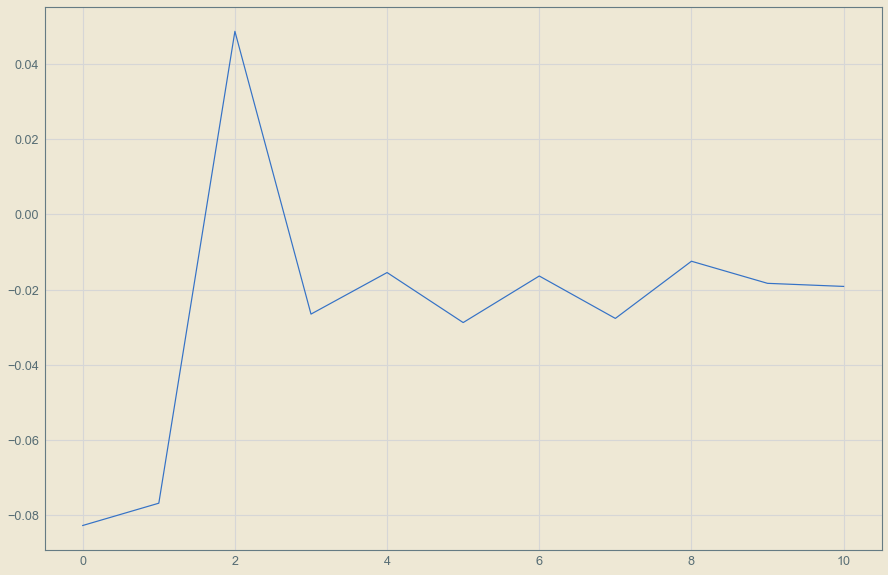

In [152]:
plt.plot(interpolate_energies(1))

In [153]:
def gb_excess(cs, gb_degeneracy, T):
    gamma = np.array([ (gb_degeneracy*occupation_excess(interpolate_energies(c), T, c)).sum() for c in cs])
    return gamma

In [154]:
np.linalg.det(gb.cell[1:, 1:])
def interpolate_gb_area(c, gb_cu = gb_cu, gb_ni = gb_ni):
    A_ni = np.linalg.det(gb_ni.cell[1:, 1:])
    A_cu = np.linalg.det(gb_cu.cell[1:, 1:])
    return A_ni + (A_cu - A_ni) * c

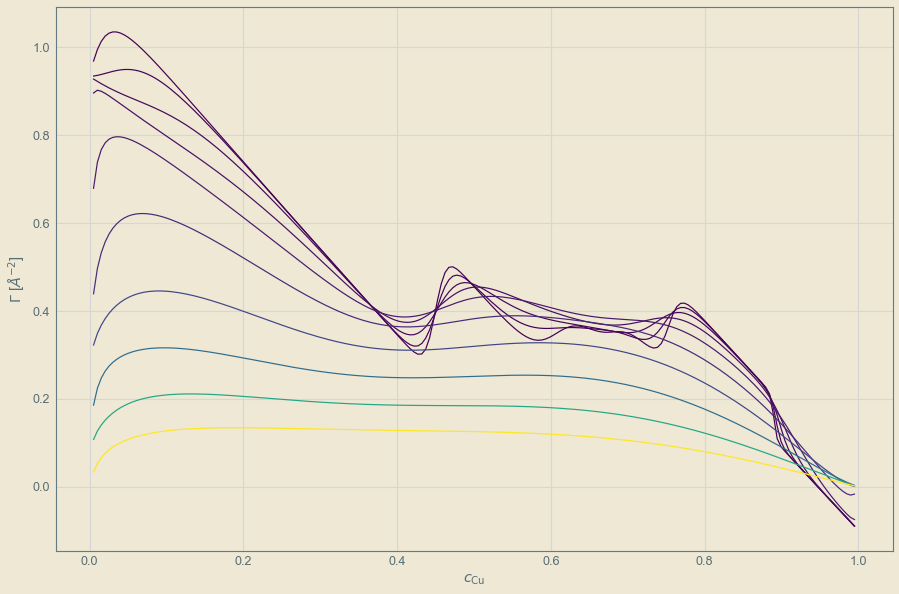

In [159]:
cs = np.linspace(0, 1, 200)[1:-1]
for c, Ti in zip(plt.cm.viridis((T-T[0])/(T[-1]-T[0])), T):
    plt.plot(cs, gb_excess(cs, gb_degeneracy, Ti)/interpolate_gb_area(cs), color = c)
plt.xlabel('$c_\mathrm{Cu}$');
plt.ylabel('$\Gamma$ [$\AA^{-2}$]');